# Create a map of the Ambulance Service regions

In England and Wales there are 11 Ambulance Services.

An image of the Ambulance Service catchments can be found at https://aace.org.uk/uk-ambulance-service/map-of-nhs-ambulance-services/ (Association of Ambulance Cheif Executives).

We have been advised by Steve Irving (Executive Officer / ALF Conference Lead) that the map "is just an approximation of the boundaries, purely for illustrative / navigational purposes".

We aim to build a map of the Ambulance Service regions from the individual LSOAs up.

Here we link together two datafiles that take us from LSOA to CCG, and then from CCG to Ambulance Service:
1) LSOA to CCG (Lower_Layer_Super_Output_Area_(2011)_to_Clinical_Commissioning_Group_to_Local_Authority_District_(April_2021)_Lookup_in_England.csv)
2) CCG to Ambulance Service ("ambulance_service_info.xlsx", sheet Ambulance CCG lookup. Extracted and created "ambulance_service_info_ccg_lookup.csv"). Do not use "NHS Ambulance Service Region Name" as this is not a name per Ambulance Service. Instead set up a dictionary and create a new field "Ambulance Service Name" from the code contained in the field "Ambulane Service".

There is a complications using this approach. Two CCGs are split across two Ambulance Services:
1) NHS Hampshire, Southampton and Isle of Wight CCG is partly covered by Isle of Wight Ambulance Service, partly by SCAS.
2) NHS Bedfordshire, Luton and Milton Keynes CCG is partly covered by EEAST, partly by SCAS.

We manage this by taking this approach:
1) All LSOA names containing "Isle of Wight" get assigned to Isle of Wight Ambulance Service, the rest of the LSOAs that make up the "NHS Hampshire, Southampton and Isle of Wight CCG" get assigned to SCAS.
2) NHS Bedfordshire, Luton and Milton Keynes CCG spans two counties: Bedfordshire and Buckinhamshire. The catchemnt maps on the respective Ambulance Service websites showed that the Ambulance Service EEAST serves the county of Bedfordhsire, and the Ambulance Service SCAS serves the county of Buckinghamshire. Using a shapefile of the UK Counties, extract the individual polygons for i) Bedfordshire ii) Buckinghamshire and in turn use these to identify the LSOAs in each. For the LSOAs in the NHS Bedfordshire, Luton and Milton Keynes CCG, use their location in relation to these two counties to determine whether they are part of the EEAST or SCAS. 

Another complication is that Wales is not included in the LSOA to CCG datafile, and so would otherwise not be included in this analysis.

Note: Code cell "gdf_beds_lsoa = gpd.clip(gdf_beds_county, gdf_lsoa)" takes a few hours to run. So read in the created shapefile (same for the Bucks equivalent)

https://geoportal.statistics.gov.uk/datasets/ons::oa-2021-to-ward-to-ltla-to-utla-to-region-to-country-may-2022-lookup-in-england-and-wales-v2/explore

https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-area-2011-to-ward-2020-lookup-in-england-and-wales-1/explore

LSOA to County source:
https://opendata.camden.gov.uk/widgets/tr8t-gqz7

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import os
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from IPython.display import Image

Source for County shapefile: https://www.ukpostcode.net/shapefile-of-uk-administrative-counties-wiki-16.html

In [2]:
filename = 'zip://./data/uk_admin_map_shapefile.zip'
gdf_county= gpd.read_file(filename, crs='EPSG:27700')
gdf_county.head(2)

DriverError: '/vsizip/./data/uk_admin_map_shapefile.zip' does not exist in the file system, and is not recognized as a supported dataset name.

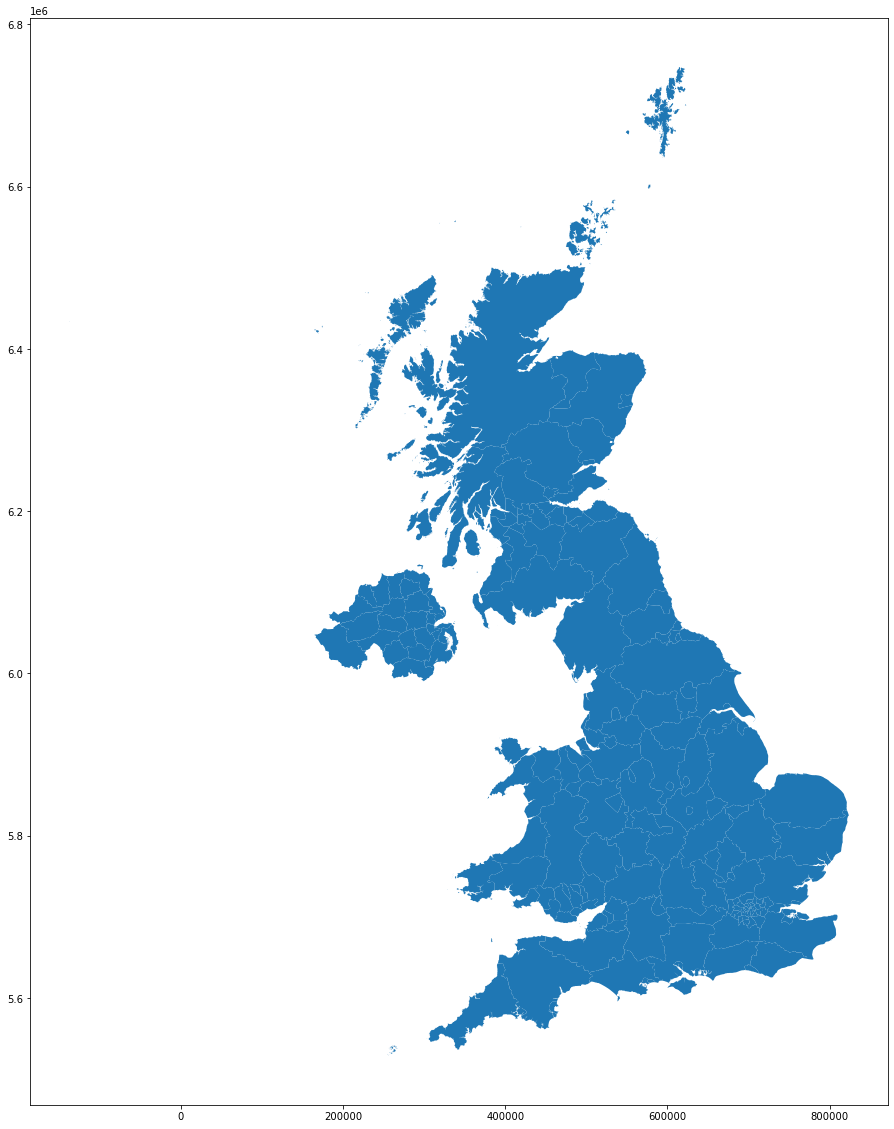

In [112]:
gdf_county.plot(figsize=(20,20));

In [113]:
filename = 'zip://./data/Counties_and_Unitary_Authorities__December_2017__Boundaries_UK-shp.zip'
gdf_county_ua= gpd.read_file(filename, crs='EPSG:27700')
gdf_county_ua.head(2)

,objectid,ctyua17cd,ctyua17nm,ctyua17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.355951e+07,71707.407523,"MULTIPOLYGON (((447213.900 537036.104, 447228...."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.388858e+07,43840.866561,"MULTIPOLYGON (((448958.901 521835.695, 449045...."


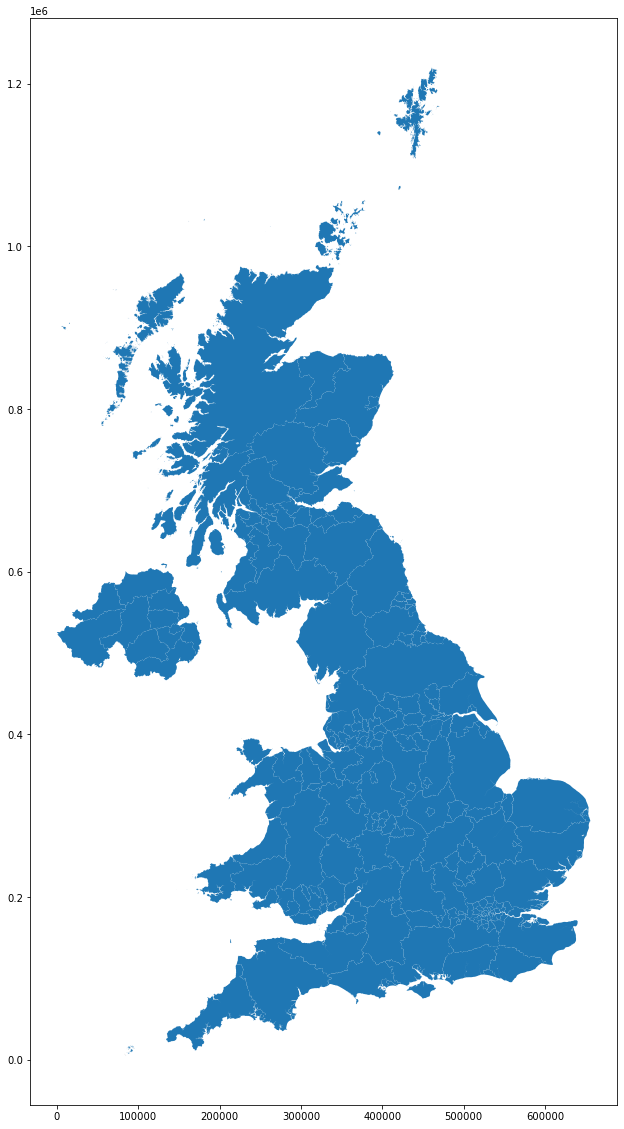

In [114]:
gdf_county_ua.plot(figsize=(20,20));

Put both county shapefiles on one plot

In [116]:
# When using base maps convert data to epsg:3857
gdf_county = gdf_county.to_crs(epsg=3857)
gdf_county_ua = gdf_county_ua.to_crs(epsg=3857)

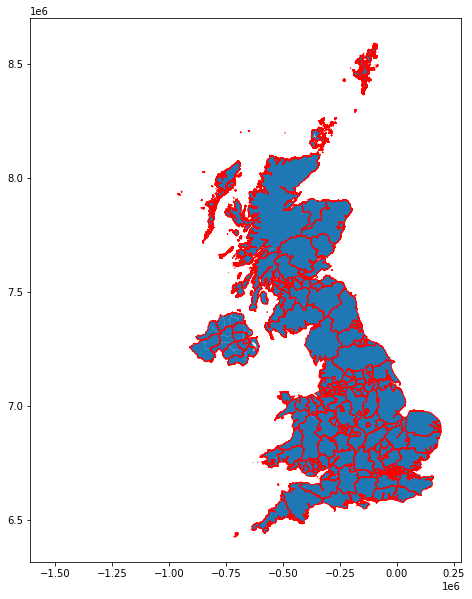

In [129]:
fig, ax = plt.subplots(figsize=(10, 10)) # Make max dimensions 10x10 inch
gdf_county.plot(ax=ax)
gdf_county_ua.plot(ax=ax, facecolor='none', edgecolor='red')
plt.set_xlim=([-75, 25])
plt.set_ylim=([650, 750])
plt.show()

In [127]:
plt.xlim

[-750000, 250000]

<AxesSubplot:>

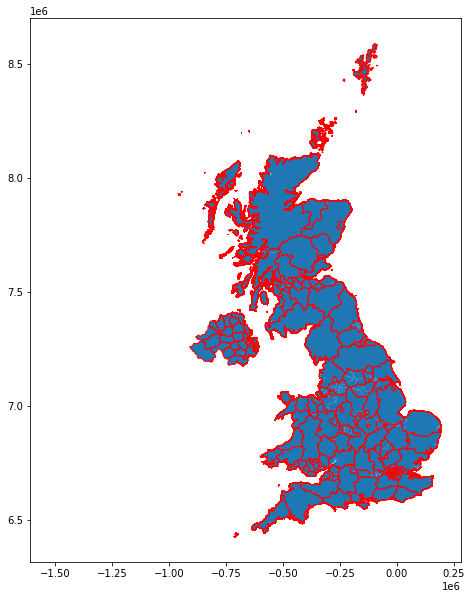

In [119]:
fig, ax = plt.subplots(figsize=(10, 10)) # Make max dimensions 10x10 inch
gdf_county_ua.plot(ax=ax)
gdf_county.plot(ax=ax, facecolor='none', edgecolor='red')


Extract the two counties need to divide the LSOAs between.

** KP note that so far only used "Bedfordshire" and "Buckinghamshire", whereas also need to add to Bedfordshire "Luton", and to Buckinghmashire "Milton Keynes".

In [4]:
mask = gdf_county["NAME_2"] == "Bedfordshire"
gdf_beds_county = gdf_county[mask]
mask = gdf_county["NAME_2"] == "Buckinghamshire"
gdf_bucks_county = gdf_county[mask]

Read in LSOA shapefile

In [5]:
filename = 'zip://./data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip'
gdf_lsoa = gpd.read_file(filename, crs='EPSG:27700')
gdf_lsoa.head()

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [19]:
filename = 'zip://./data/Lower_Layer_Super_Output_Area_(2011)_to_Ward_(2020)_Lookup_in_England_and_Wales.gdb.zip'
gdf_ward= gpd.read_file(filename, crs='EPSG:27700')
gdf_ward.head(2)

,LSOA11CD,LSOA11NM,WD20CD,WD20NM,LAD20CD,LAD20NM,geometry
0,E01011949,Hartlepool 009A,E05008945,Foggy Furze,E06000001,Hartlepool,None
1,E01012162,Redcar and Cleveland 012A,E05012454,Skelton East,E06000003,Redcar and Cleveland,None


In [16]:
gdf_lsoa["LSOA11NM"].filter(regex='edford')

Series([], Name: LSOA11NM, dtype: object)

Find LSOAs that are in Bedfordshire, and give them Ambulance Service "East of England".
Find LSOAs that are in Buckinghamshire, and give them Ambulance Service "South Central".

In [6]:
# When using base maps convert data to epsg:3857
gdf_lsoa = gdf_lsoa.to_crs(epsg=3857)
gdf_beds_county = gdf_beds_county.to_crs(epsg=3857)
gdf_bucks_county = gdf_bucks_county.to_crs(epsg=3857)

Check location of county sits within LSOA maps (check the crs match across all three shapefiles)

<AxesSubplot:>

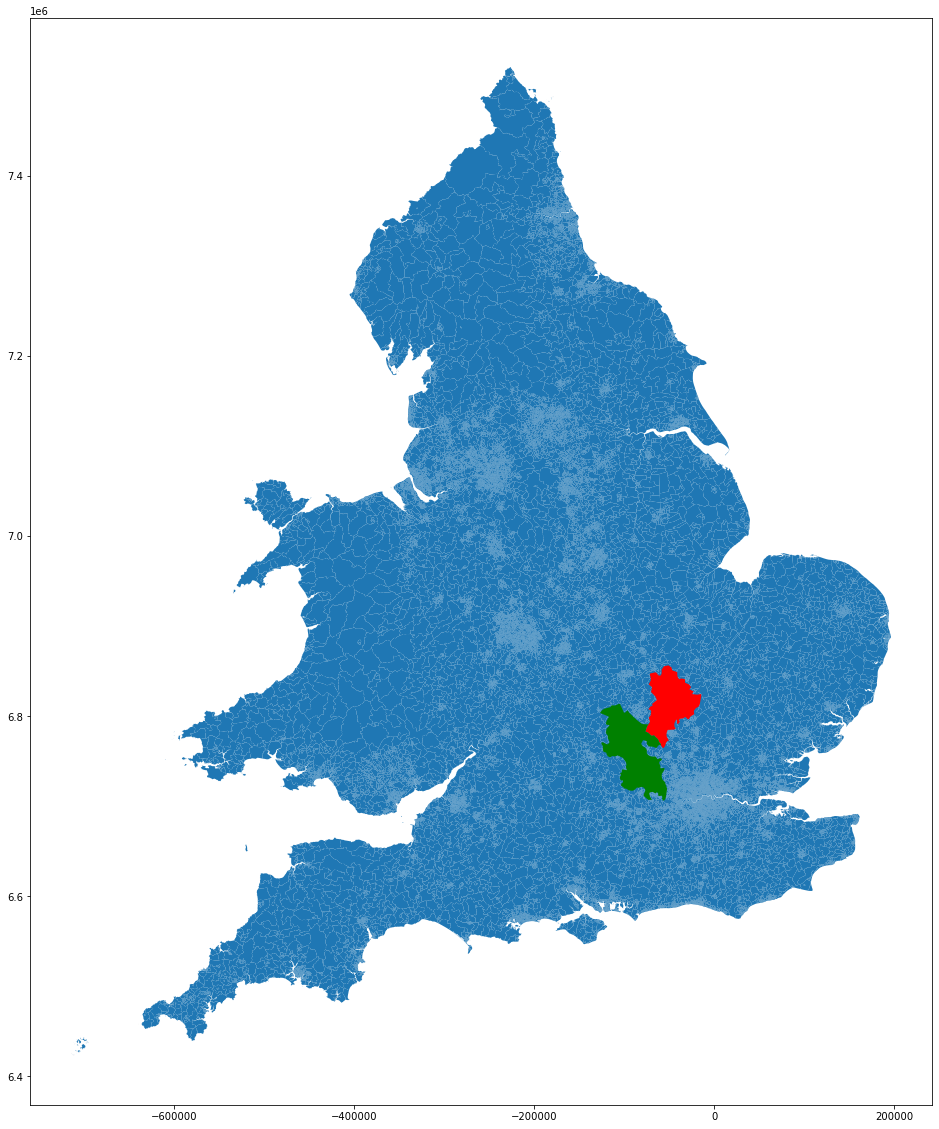

In [7]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax)
gdf_beds_county.plot(ax=ax, facecolor='red')
gdf_bucks_county.plot(ax=ax, facecolor='green')

Limit the LSOA shapefile to the boundary around the county polygon, before do clip method, to save a lot of processing time

In [57]:
beds_county_bounds = gdf_beds_county.bounds
minx,miny,maxx,maxy =  beds_county_bounds.iloc[0]
gdf_beds_lsoa_box = gdf_lsoa.cx[minx:maxx,miny:maxy]

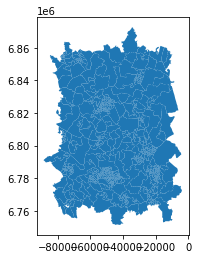

In [9]:
gdf_beds_lsoa_box.plot();

In [74]:
gdf_beds_lsoa_box.to_file(f"data/lsoa_bedfordshire_box.shp")

<AxesSubplot:>

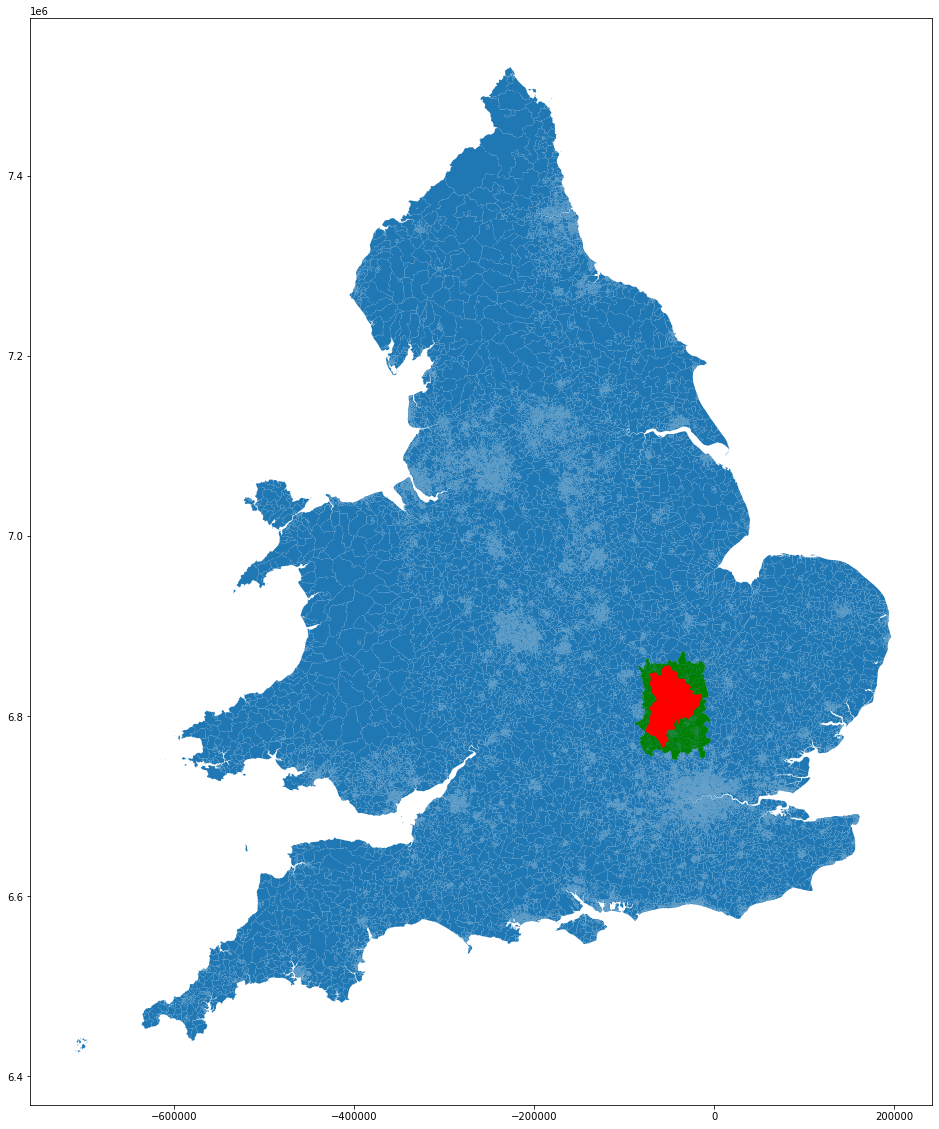

In [10]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax)
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_county.plot(ax=ax, facecolor='red')

In [31]:
gdf_beds_county_geometry = gdf_beds_county.geometry

In [37]:
gdf_beds_county_geometry

2    POLYGON ((-41311.888 6848688.907, -41002.642 6...
Name: geometry, dtype: geometry

In [38]:
# Check for LSOA overlapping with, or completely within, Devon & Cornwall
mask = (gdf_beds_lsoa_box.geometry.overlaps(gdf_beds_county_geometry))# | (gdf_beds_lsoa_box.within(gdf_beds_county))
#mask = gdf_beds_lsoa_box.within(gdf_beds_county)
gdf_beds_lsoa = gdf_beds_lsoa_box[mask]

/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/geopandas/base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/geopandas/geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [39]:
mask.sum()

0

In [23]:
gdf_beds_lsoa_box.head(2)

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
15225,E01015693,Luton 007A,Luton 007A,"POLYGON ((-46419.247 6783036.594, -46408.496 6..."
15226,E01015694,Luton 007B,Luton 007B,"POLYGON ((-46615.661 6782608.227, -46596.131 6..."


In [24]:
gdf_beds_county.head(2)

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,HASC_2,CC_2,TYPE_2,ENGTYPE_2,VALIDFR_2,VALIDTO_2,REMARKS_2,Shape_Leng,Shape_Area,geometry
2,80,GBR,United Kingdom,1030,England,13938,Bedfordshire,None,None,GB.BD,None,Administrative County,Administrative County,~1989,Present,None,2.158565,0.147815,"POLYGON ((-41311.888 6848688.907, -41002.642 6..."


In [27]:
gdf_beds_lsoa.head(2)

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry


/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


<AxesSubplot:>

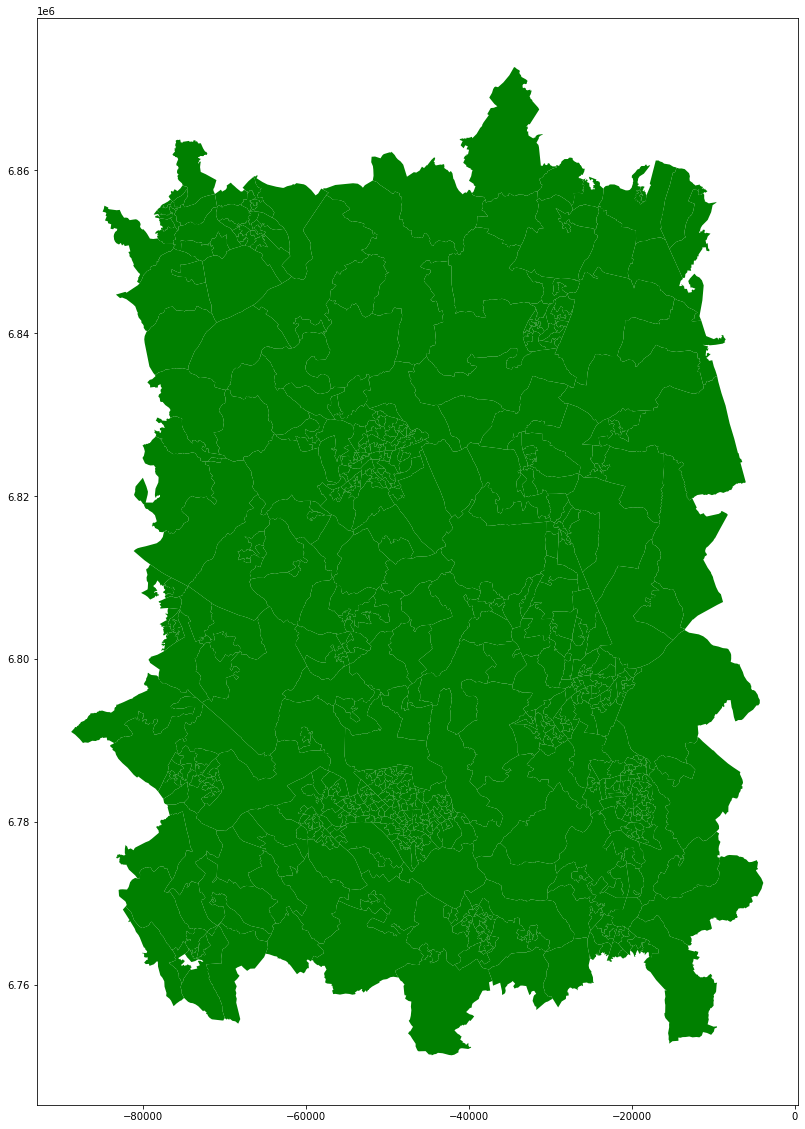

In [22]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
#gdf_lsoa.plot(ax=ax)
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_lsoa.plot(ax=ax, facecolor='red')

https://www.tomasbeuzen.com/python-for-geospatial-analysis/chapters/chapter1_intro-to-spatial.html

Take the LSOAs that sit wtihin the county polygon. Using the Clip method: "think of “clipping” as passing a top layer of cookie dough (the map above), over a bottom layer cookiecutter (our high-resolution provinces data) to get a shape out"

In [15]:
filename = "data/bedfordshire_lsoas1.shp"
exist = os.path.exists(filename)
if exist:
    # Read in
    gdf_beds_lsoa = gpd.read_file(filename, crs='EPSG:27700')
else:
    # Create IVT catchment shapefile by dissolving LSOA polygons
    gdf_beds_lsoa = gpd.clip(gdf_beds_lsoa_box, gdf_beds_county)

    # Save a shapefile of the catchments for each IVT
    gdf_beds_lsoa.to_file(filename)

TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -48331.645175062782 6821220.2919420162 at -48331.645175062782 6821220.2919420162


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fecc6cb5d90>

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax)
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_county.plot(ax=ax, facecolor='red')
gdf_beds_lsoa.plot(ax=ax, facecolor='blue')

In [ ]:
bucks_county_bounds = gdf_bucks_county.bounds
minx,miny,maxx,maxy =  bucks_county_bounds.iloc[0]
gdf_bucks_lsoa_box = gdf_lsoa.cx[minx:maxx,miny:maxy]

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax)
gdf_bucks_lsoa_box.plot(ax=ax, facecolor='green')
gdf_bucks_county.plot(ax=ax, facecolor='red')

In [ ]:
filename = "data/buckinghamshire_lsoas1.shp"
exist = os.path.exists(filename)
if exist:
    # Read in
    gdf_bucks_lsoa = gpd.read_file(filename, crs='EPSG:27700')
else:
    # Create IVT catchment shapefile by dissolving LSOA polygons
    gdf_bucks_lsoa = gpd.clip(gdf_bucks_lsoa_box, gdf_bucks_county)

    # Save a shapefile of the catchments for each IVT
    gdf_bucks_lsoa.to_file(filename)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax)
gdf_bucks_lsoa_box.plot(ax=ax, facecolor='green')
gdf_bucks_county.plot(ax=ax, facecolor='red')
gdf_bucks_lsoa.plot(ax=ax, facecolor='blue')

gdf_beds_lsoa = gpd.clip(gdf_beds_county, gdf_lsoa)
gdf_beds_lsoa.plot(edgecolor="0.2")

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax)
gdf_beds_lsoa.plot(ax=ax, facecolor='red')
gdf_bucks_lsoa.plot(ax=ax, facecolor='green')

# NEW APPROACH WITH COUNTY LOOKUP FILES

In [41]:
lsoa_to_county = pd.read_csv("data/National_Statistics_Postcode_Lookup_UK.csv")
lsoa_to_county.head(2)

,Postcode 1,Postcode 2,Postcode 3,Date Introduced,User Type,Easting,Northing,Positional Quality,County Code,County Name,...,Middle Super Output Area Code,Middle Super Output Area Name,Output Area Classification Code,Output Area Classification Name,Longitude,Latitude,Spatial Accuracy,Last Uploaded,Location,Socrata ID
0,RM1 3DB,RM1 3DB,RM1 3DB,01-1980,0,551820,189380,1,E09000016,NaN,...,E02000475,Havering 012,5B1,Urbanites;Ageing urban living;Delayed retirement,0.189869,51.582836,Postcode Level,05/12/2022,"(51.582836, 0.189869)",1320003
1,SM1 4NR,SM1 4NR,SM1 4NR,01-1980,0,526554,164361,1,E09000029,NaN,...,E02000852,Sutton 013,4C3,Multicultural metropolitans;Asian traits;Inner...,-0.183560,51.364224,Postcode Level,05/12/2022,"(51.364224, -0.18356)",1447628


In [64]:
cols = ["County Code","County Name", "Lower Super Output Area Code"]
lsoa_to_county_trim = lsoa_to_county[cols]
lsoa_to_county_trim = lsoa_to_county_trim.drop_duplicates()
lsoa_to_county_trim.head(2)

,County Code,County Name,Lower Super Output Area Code
0,E09000016,NaN,E01002354
1,E09000029,NaN,E01004139


In [73]:
lsoa_to_county_trim.to_csv("data/National_Statistics_Postcode_Lookup_UK_trim_lsoa_county.csv")

In [65]:
beds_county_bounds = gdf_beds_county.bounds
minx,miny,maxx,maxy =  beds_county_bounds.iloc[0]
gdf_beds_lsoa_box = gdf_lsoa.cx[minx:maxx,miny:maxy]

In [66]:
gdf_beds_lsoa_box.head(2)

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
15225,E01015693,Luton 007A,Luton 007A,"POLYGON ((-46419.247 6783036.594, -46408.496 6..."
15226,E01015694,Luton 007B,Luton 007B,"POLYGON ((-46615.661 6782608.227, -46596.131 6..."


In [67]:
gdf_beds_lsoa_box.set_index("LSOA11CD", inplace=True)

In [68]:
lsoa_to_county_trim.set_index("Lower Super Output Area Code", inplace=True)

In [69]:
lsoa_to_county_trim.head(2)

,County Code,County Name
Lower Super Output Area Code,,
E01002354,E09000016,NaN
E01004139,E09000029,NaN


In [70]:
gdf_beds_lsoa_box = gdf_beds_lsoa_box.join(lsoa_to_county_trim).reset_index()
gdf_beds_lsoa_box.head(2)

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry,County Code,County Name
0,E01015693,Luton 007A,Luton 007A,"POLYGON ((-46419.247 6783036.594, -46408.496 6...",E06000032,NaN
1,E01015694,Luton 007B,Luton 007B,"POLYGON ((-46615.661 6782608.227, -46596.131 6...",E06000032,NaN


<AxesSubplot:>

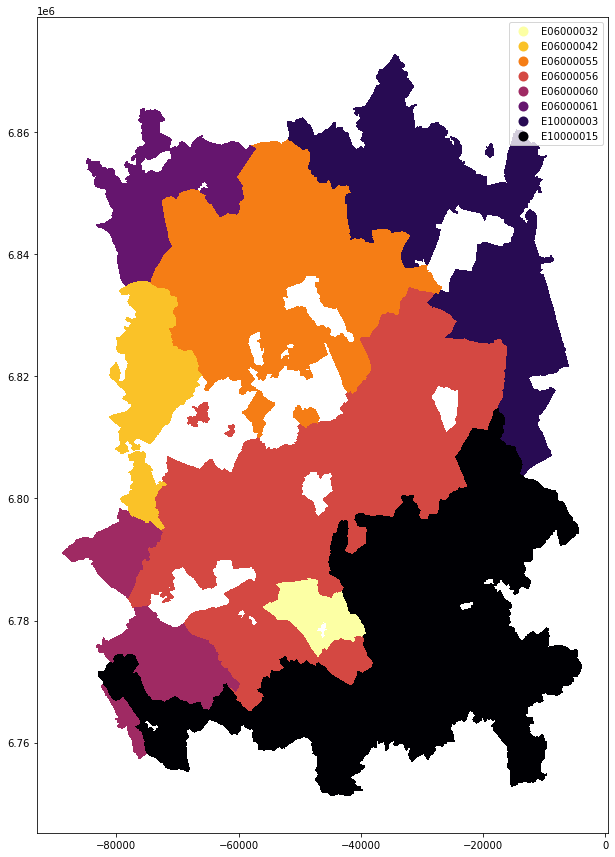

In [72]:
fig, ax = plt.subplots(figsize=(15, 15)) # Make max dimensions 10x10 inch
gdf_beds_lsoa_box.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column="County Code", # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r',
                      legend=True)

County Code Names
Luton: E06000032
Milton keynes: E06000042
Bedford: E06000055
Central Bedfordshure: E06000056
Bucks: E06000060
North Northamptonshire: E06000061
Cambridgeshire: E10000003
Hertfordshire: E10000015

## Used QGIS to find out why there's holes

It's just because the oa to county file (data/National_Statistics_Postcode_Lookup_UK.csv) appears to be incomplete for those missing LSOAs. Not an issue with the join.

:(

But did find another shapefile for Counties (from UA)

In [77]:
filename = 'zip://./data/Counties_and_Unitary_Authorities__December_2017__Boundaries_UK-shp.zip'
gdf_county_ua= gpd.read_file(filename, crs='EPSG:27700')
gdf_county_ua.head(2)

,objectid,ctyua17cd,ctyua17nm,ctyua17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.355951e+07,71707.407523,"MULTIPOLYGON (((447213.900 537036.104, 447228...."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.388858e+07,43840.866561,"MULTIPOLYGON (((448958.901 521835.695, 449045...."


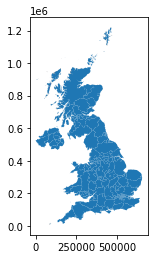

In [78]:
gdf_county_ua.plot();

Join up the 3 polygons to make up Bedford county and try to use this to ".clip" the LSOA shapefile (spoiler - you will see it gives the same error as before, so the issue seems to be with the LSOA shapefile.

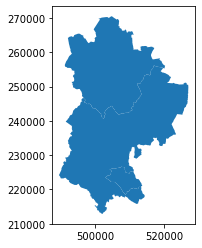

In [82]:
mask = (gdf_county_ua["ctyua17nm"] == "Bedford")|(gdf_county_ua["ctyua17nm"] == "Central Bedfordshire")|(gdf_county_ua["ctyua17nm"] == "Luton")
gdf_beds_county_ua = gdf_county_ua[mask]
gdf_beds_county_ua = gdf_beds_county_ua.to_crs(epsg=3857)
gdf_beds_county_ua.plot();

In [92]:
gdf_beds_county_ua['common_column'] = "Yes"
gdf_beds_county_ua_merged = gdf_beds_county_ua.dissolve(by='common_column')
gdf_beds_county_ua_merged.head()

/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,objectid,ctyua17cd,ctyua17nm,ctyua17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths
common_column,,,,,,,,,,,
Yes,"POLYGON ((511131.303 225358.101, 511124.699 22...",32,E06000032,Luton,None,508606,222559,-0.42319,51.891022,4.335249e+07,34569.65994


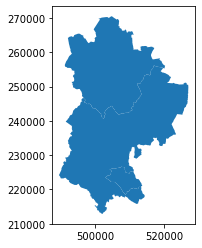

In [93]:
gdf_beds_county_ua.plot();

In [98]:
gdf_beds_county_ua.to_file(f"data/bedfordshire_county_from_3uas.shp")

<AxesSubplot:>

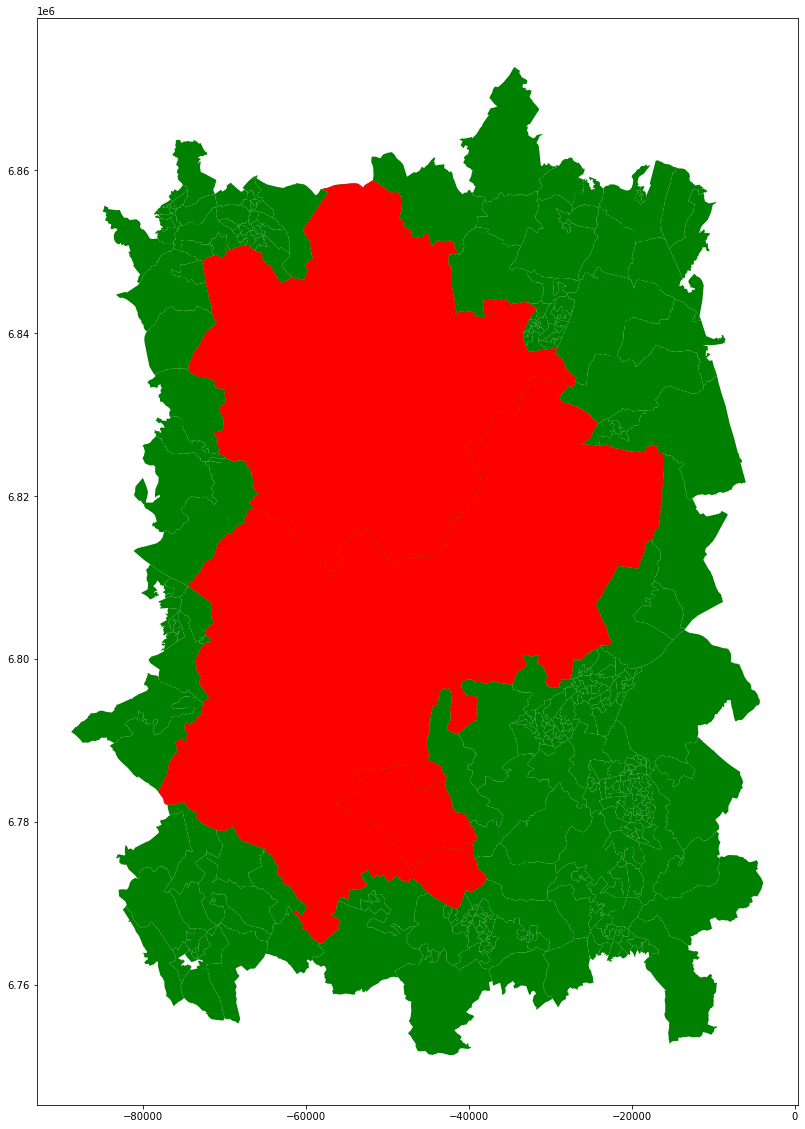

In [96]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_county_ua.plot(ax=ax, facecolor='red')

In [97]:
gdf_beds_lsoa = gpd.clip(gdf_beds_lsoa_box, gdf_beds_county_ua)

TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -48331.645175062782 6821220.2919420162 at -48331.645175062782 6821220.2919420162


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fecc6cb5d90>

In [99]:
filename = 'zip://./data/Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.zip'
gdf_lsoa_1 = gpd.read_file(filename, crs='EPSG:27700')
gdf_lsoa_1.head()

DriverError: '/vsizip/./data/Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.zip' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
gdf_lsoa_1.plot();

Followed how to clip in QGIS (lsoa_bedfordshire_box.shp and bedfordshire_county_from_3uas.shp)
https://www.youtube.com/watch?v=U3pngCq3TFw
Created "bedfordshire_lsoas.gpkg"

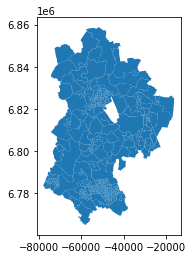

In [101]:
filename = "data/bedfordshire_lsoas.gpkg"
gdf_beds_lsoa_qgis = gpd.read_file(filename, crs='EPSG:27700')
gdf_beds_lsoa_qgis.plot();

<AxesSubplot:>

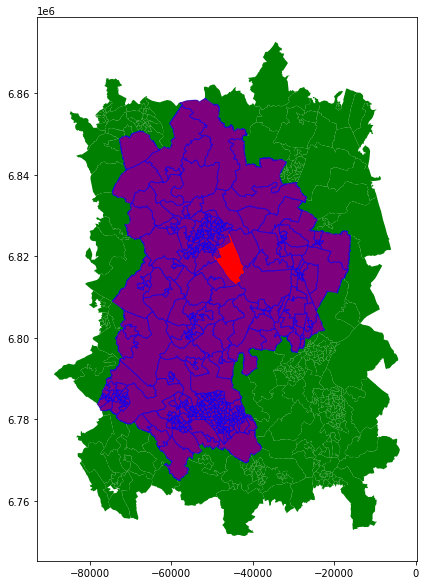

In [107]:
fig, ax = plt.subplots(figsize=(10, 10)) # Make max dimensions 10x10 inch
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_county_ua.plot(ax=ax, facecolor='red')
gdf_beds_lsoa_qgis.plot(ax=ax, facecolor='blue', edgecolor="blue", alpha = 0.5)

In [103]:
extra_lsoa_in_bedford = "E01017486"
# This exists in "gdf_beds_lsoa_box", but not currently in "gdf_beds_lsoa_qgis"

In [108]:
mask = gdf_beds_lsoa_box['LSOA11CD'] == extra_lsoa_in_bedford
gdf_beds_lsoa_qgis_plusone = gdf_beds_lsoa_qgis.copy(deep=True)
nrows = gdf_beds_lsoa_qgis_plusone.shape[0]
nrows

431

In [109]:
gdf_beds_lsoa_qgis_plusone.iloc[nrows] = gdf_beds_lsoa_box[mask]
gdf_beds_lsoa_qgis_plusone.shape

IndexError: iloc cannot enlarge its target object

In [110]:
gdf_beds_lsoa_box[mask]

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry,County Code,County Name
247,E01017486,Bedford 019A,Bedford 019A,"POLYGON ((-48331.645 6821220.292, -48326.382 6...",NaN,NaN


In [111]:
gdf_beds_lsoa_qgis_plusone.head(2)

,LSOA11CD,LSOA11NM,LSOA11NMW,County Cod,County Nam,National_Statistics_Postcode_Lookup_UK_trim_lsoa_county_County Code,National_Statistics_Postcode_Lookup_UK_trim_lsoa_county_County Name,geometry
0,E01015693,Luton 007A,Luton 007A,E06000032,None,E06000032,None,"MULTIPOLYGON (((-46419.247 6783036.594, -46408..."
1,E01015694,Luton 007B,Luton 007B,E06000032,None,E06000032,None,"MULTIPOLYGON (((-46615.661 6782608.227, -46596..."


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10)) # Make max dimensions 10x10 inch
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_county_ua.plot(ax=ax, facecolor='red')
gdf_beds_lsoa_qgis_plusone.plot(ax=ax, facecolor='blue', edgecolor="blue", alpha = 0.5)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_beds_lsoa_box.plot(ax=ax, facecolor='green')
gdf_beds_county_ua.plot(ax=ax, facecolor='red')
gdf_beds_lsoa_qgis.plot(ax=ax, facecolor='none', edgecolor="blue")